In [1]:
!pip install segmentation_models_pytorch datasets torchmetrics wandb torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 111.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.9/288.9 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
import albumentations as A
import numpy as np
import pandas as pd
import wandb
import torchvision.transforms as tvt
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from tqdm.auto import tqdm
from torchmetrics import MetricCollection
from torchmetrics.classification import Accuracy, JaccardIndex, Dice, AUROC, F1Score
from torchmetrics.regression import PearsonCorrCoef, SpearmanCorrCoef
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from pathlib import Path
from PIL import Image

import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import linregress

import copy
import segmentation_models_pytorch as smp

In [3]:
from huggingface_hub import login
from google.colab import userdata
import wandb

login(token=userdata.get('HF_TOKEN'))
wandb.login(key=userdata.get('WANDB_API_KEY'))

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
from datasets import load_dataset
from pathlib import Path
from huggingface_hub import hf_hub_download
import pandas as pd

def load_railsem_dataset():
    railsem_ds = load_dataset("BhavanaMalla/railsem19-semantic-expanded")
    return railsem_ds

def load_splits():
    print("[INFO]: Loading splits")
    data_directory = Path(".")
    csv_file_path = data_directory / "RAIL_SEM19_split.csv"
    if csv_file_path.is_file():
        print(f"[INFO]: Found {csv_file_path}.Skipping Download...")
    else:
        print("[INFO]: Downloading RAIL_SEM19_split.csv from hub")
        csv_file_path = hf_hub_download(
            repo_id="BhavanaMalla/railsem19-semantic-expanded",
            filename="RAIL_SEM19_split.csv",
            repo_type="dataset",
            local_dir=data_directory
        )
    splits_df = pd.read_csv(csv_file_path)

    # Filter rows based on type
    train_names = splits_df[splits_df["type"] == "Train"]["Names"].tolist()
    val_names = splits_df[splits_df["type"] == "Validation"]["Names"].tolist()
    test_names = splits_df[splits_df["type"] == "Test"]["Names"].tolist()
    return train_names, val_names, test_names

In [5]:
import torchvision.transforms as tvt

def apply_transforms(data): #example
    image_transform = tvt.Compose([
        tvt.ToTensor(),
    ])
    mask_transform = tvt.Compose([
        tvt.PILToTensor(),
    ])

    transformed_images = [image_transform(img) for img in data["image"]]
    transformed_masks = [mask_transform(mask) for mask in data["semantic_mask_label"]]

    return {
        "image": transformed_images,
        "semantic_mask_label": transformed_masks,
        "img_Name": data["img_Name"]
    }


In [7]:
# val split
from datasets import DatasetDict, load_from_disk, Dataset


railsem_ds = load_railsem_dataset()
dataset = railsem_ds["data"]
train_names, val_names, test_names = load_splits()
val_idxs = []
dataset.map(lambda img, idx: (val_idxs.append(idx) if img["img_Name"] in val_names else None), with_indices=True,
            remove_columns=['objs_labels', 'objs_bboxes', 'objs_polygons', 'objs_lpolyline', 'objs_polyline-pair', 'img_Height', 'img_Width',])
val_split = dataset.select(val_idxs)

[INFO]: Loading splits
[INFO]: Found RAIL_SEM19_split.csv.Skipping Download...


Map:   0%|          | 0/8500 [00:00<?, ? examples/s]

In [9]:
len(val_names), val_split

(765,
 Dataset({
     features: ['image', 'semantic_mask_label', 'objs_labels', 'objs_bboxes', 'objs_polygons', 'objs_lpolyline', 'objs_polyline-pair', 'img_Height', 'img_Width', 'img_Name'],
     num_rows: 765
 }))

In [10]:
railsem_ds = load_railsem_dataset()
dataset = railsem_ds["data"]
train_names, val_names, test_names = load_splits()
val_idxs = []

# Use map to identify validation indices
def get_val_indices(example, idx):
    if example["img_Name"] in val_names:
        val_idxs.append(idx)
    return example

remove_columns = ['objs_labels', 'objs_bboxes', 'objs_polygons', 'objs_lpolyline', 'objs_polyline-pair', 'img_Height', 'img_Width']
# Apply map function
dataset.map(get_val_indices, with_indices=True)

# Select the validation split based on indices
val_split = dataset.select(val_idxs)

# Remove specified columns from val_split
val_split = val_split.remove_columns(remove_columns)

[INFO]: Loading splits
[INFO]: Found RAIL_SEM19_split.csv.Skipping Download...


Map:   0%|          | 0/8500 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'semantic_mask_label', 'img_Name'],
    num_rows: 765
})

In [12]:
len(val_idxs), val_split

(765,
 Dataset({
     features: ['image', 'semantic_mask_label', 'img_Name'],
     num_rows: 765
 }))

In [13]:
def create_dataset(val_split):
    val_dataset = DatasetDict({"val": val_split})
    return val_dataset

val_dataset = create_dataset(val_split)

val_dataset

DatasetDict({
    val: Dataset({
        features: ['image', 'semantic_mask_label', 'img_Name'],
        num_rows: 765
    })
})

In [14]:
val_dataset, val_dataset["val"].features, dataset, dataset.features

(DatasetDict({
     val: Dataset({
         features: ['image', 'semantic_mask_label', 'img_Name'],
         num_rows: 765
     })
 }),
 {'image': Image(mode=None, decode=True, id=None),
  'semantic_mask_label': Image(mode=None, decode=True, id=None),
  'img_Name': Value(dtype='string', id=None)},
 Dataset({
     features: ['image', 'semantic_mask_label', 'objs_labels', 'objs_bboxes', 'objs_polygons', 'objs_lpolyline', 'objs_polyline-pair', 'img_Height', 'img_Width', 'img_Name'],
     num_rows: 8500
 }),
 {'image': Image(mode=None, decode=True, id=None),
  'semantic_mask_label': Image(mode=None, decode=True, id=None),
  'objs_labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
  'objs_bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
  'objs_polygons': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),

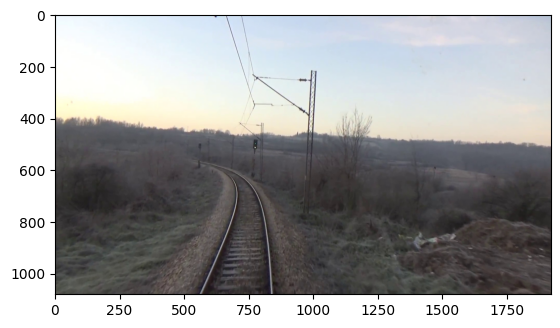

In [15]:
import matplotlib.pyplot as plt
plt.imshow(val_dataset["val"][0]["image"])
plt.show()

In [16]:
val_dataset.push_to_hub("BhavanaMalla/railsem19_val_split", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/765 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/BhavanaMalla/railsem19_val_split/commit/ba519f5f2b5cc2bee2744a0c822fd1debe58abab', commit_message='Upload dataset', commit_description='', oid='ba519f5f2b5cc2bee2744a0c822fd1debe58abab', pr_url=None, pr_revision=None, pr_num=None)

In [17]:
# Train dataset
railsem_ds = load_railsem_dataset()
dataset = railsem_ds["data"]
train_names, val_names, test_names = load_splits()
train_idxs = []

# Use map to identify train indices
def get_train_indices(example, idx):
    if example["img_Name"] in train_names:
        train_idxs.append(idx)
    return example


def create_dataset(mydataset):
    remove_columns = ['objs_labels', 'objs_bboxes', 'objs_polygons', 'objs_lpolyline', 'objs_polyline-pair', 'img_Height', 'img_Width']

    # Apply map function
    dataset.map(get_train_indices, with_indices=True)

    # Select the train split based on indices
    train_split = dataset.select(train_idxs)

    # Remove specified columns from val_split
    train_split = train_split.remove_columns(remove_columns)

    train_dataset = DatasetDict({"train": train_split})
    return train_dataset

train_dataset = create_dataset(dataset)

train_dataset

[INFO]: Loading splits
[INFO]: Found RAIL_SEM19_split.csv.Skipping Download...


Map:   0%|          | 0/8500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'semantic_mask_label', 'img_Name'],
        num_rows: 5950
    })
})

In [18]:
train_dataset, train_dataset["train"].features, dataset, dataset.features

(DatasetDict({
     train: Dataset({
         features: ['image', 'semantic_mask_label', 'img_Name'],
         num_rows: 5950
     })
 }),
 {'image': Image(mode=None, decode=True, id=None),
  'semantic_mask_label': Image(mode=None, decode=True, id=None),
  'img_Name': Value(dtype='string', id=None)},
 Dataset({
     features: ['image', 'semantic_mask_label', 'objs_labels', 'objs_bboxes', 'objs_polygons', 'objs_lpolyline', 'objs_polyline-pair', 'img_Height', 'img_Width', 'img_Name'],
     num_rows: 8500
 }),
 {'image': Image(mode=None, decode=True, id=None),
  'semantic_mask_label': Image(mode=None, decode=True, id=None),
  'objs_labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
  'objs_bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
  'objs_polygons': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=Non

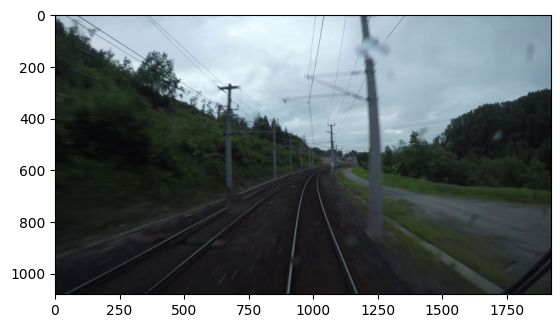

In [19]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset["train"][0]["image"])
plt.show()

In [20]:
train_dataset.push_to_hub("BhavanaMalla/railsem19_train_split", private=True)

Uploading the dataset shards:   0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Map:   0%|          | 0/743 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Map:   0%|          | 0/743 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/BhavanaMalla/railsem19_train_split/commit/7a62678bcaf353eb6259e5138650cebc51b09894', commit_message='Upload dataset', commit_description='', oid='7a62678bcaf353eb6259e5138650cebc51b09894', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from datasets import DatasetDict, load_from_disk, Dataset


railsem_ds = load_railsem_dataset()
dataset = railsem_ds["data"]
_, _, test_names = load_splits()
test_idxs = []
dataset.map(lambda img, idx: (test_idxs.append(idx) if img["img_Name"] in test_names else None), with_indices=True)
test_split = dataset.select(test_idxs)
# test_split = test_split.select(indices=range(8))

Generating data split:   0%|          | 0/8500 [00:00<?, ? examples/s]

[INFO]: Loading splits
[INFO]: Downloading RAIL_SEM19_split.csv from hub


RAIL_SEM19_split.csv:   0%|          | 0.00/121k [00:00<?, ?B/s]

Map:   0%|          | 0/8500 [00:00<?, ? examples/s]

In [ ]:
from torchvision.transforms.functional import to_pil_image
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2
tvt_transform = tvt.Compose([
    tvt.PILToTensor(),
])
transform = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.9, saturation=0.9, hue=0.2, always_apply=True, p=1),
    ToTensorV2()
])

# Define a function to apply the transformations to each sample
def apply_transform(sample):
    print(sample)
    img = tvt_transform(sample["image"])
    mask = tvt_transform(sample["semantic_mask_label"])
    print(img.shape, mask.shape)
    transformed = transform(image=img.permute(1, 2, 0).numpy(), mask=mask.squeeze().numpy())
    name = sample["img_Name"]
    print(transformed["image"].shape, transformed["mask"].shape, transformed["mask"].unsqueeze(0).shape)
    sample["image"] = to_pil_image(transformed["image"])
    sample["semantic_mask_label"] = to_pil_image(transformed["mask"].unsqueeze(0))
    return sample


test_split = test_split.select(indices=range(2))
transformed_dataset = test_split.map(apply_transform,
                                     remove_columns=['objs_labels', 'objs_bboxes', 'objs_polygons', 'objs_lpolyline', 'objs_polyline-pair', 'img_Height', 'img_Width',])
transformed_dataset

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080 at 0x7A05262852A0>, 'semantic_mask_label': <PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1080 at 0x7A0526287250>, 'objs_labels': ['pole', 'rail', 'rail', 'guard-rail', 'guard-rail'], 'objs_bboxes': [None, None, None, None, None], 'objs_polygons': [[[238, 1015], [214, 999], [214, 628], [254, 325], [312, 104], [277, 70], [264, 0], [657, 0], [641, 38], [517, 171], [429, 343], [384, 556], [368, 731], [378, 944], [413, 960]], None, None, None, None], 'objs_lpolyline': [None, None, None, [[667, 1079], [668, 1076], [670, 1073], [671, 1070], [673, 1067], [674, 1064], [676, 1061], [677, 1058], [679, 1055], [680, 1052], [682, 1049], [684, 1046], [685, 1043], [687, 1040], [688, 1037], [690, 1034], [691, 1031], [693, 1028], [694, 1025], [696, 1022], [697, 1019], [699, 1016], [701, 1013], [702, 1009], [704, 1006], [705, 1003], [707, 1000], [708, 997], [710, 994], [711, 991], [713, 988], [714, 985], [716, 982], [718

Dataset({
    features: ['image', 'semantic_mask_label', 'img_Name'],
    num_rows: 2
})

In [ ]:
test_split.features

{'image': Image(mode=None, decode=True, id=None),
 'semantic_mask_label': Image(mode=None, decode=True, id=None),
 'objs_labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'objs_bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'objs_polygons': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
 'objs_lpolyline': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
 'objs_polyline-pair': Sequence(feature=Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
 'img_Height': Value(dtype='int64', id=None),
 'img_Width': Value(dtype='int64', id=None),
 'img_Name': Value(dtype='string', id=None)}

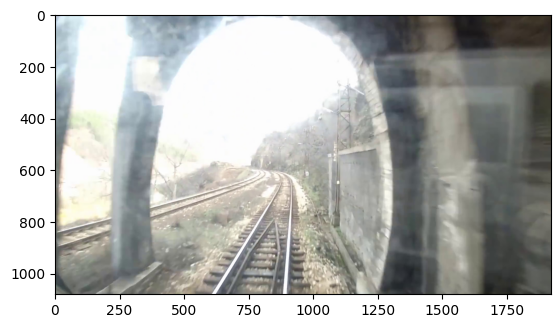

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(test_split[0]["image"])
plt.show()

In [ ]:
transformed_dataset.features

In [ ]:
def create_dataset(test_split):
    test_data = test_split.map(apply_transforms, batched=True,
                               remove_columns=dataset.column_names,
                               batch_size=3)
    test_dataset = DatasetDict({"test": test_data})

    return test_dataset

test_dataset = create_dataset(test_split)



Map:   0%|          | 0/1785 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:339: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


In [ ]:
test_dataset, test_dataset["test"].features, dataset, dataset.features

(DatasetDict({
     test: Dataset({
         features: ['image', 'semantic_mask_label', 'img_Name'],
         num_rows: 1785
     })
 }),
 {'image': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
  'semantic_mask_label': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='uint8', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
  'img_Name': Value(dtype='string', id=None)},
 Dataset({
     features: ['image', 'semantic_mask_label', 'objs_labels', 'objs_bboxes', 'objs_polygons', 'objs_lpolyline', 'objs_polyline-pair', 'img_Height', 'img_Width', 'img_Name'],
     num_rows: 8500
 }),
 {'image': Image(mode=None, decode=True, id=None),
  'semantic_mask_label': Image(mode=None, decode=True, id=None),
  'objs_labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
  'objs_bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', i

In [ ]:
test_dataset.push_to_hub("BhavanaMalla/railsem19_test_split_original", private=True)

Uploading the dataset shards:   0%|          | 0/97 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/BhavanaMalla/railsem19_test_split_original/commit/c612769706f0231480a59ba54d9556126561a20c', commit_message='Upload dataset (part 00001-of-00002)', commit_description='', oid='c612769706f0231480a59ba54d9556126561a20c', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
test_original = load_dataset("BhavanaMalla/railsem19_test_split_original")
test_original

Resolving data files:   0%|          | 0/97 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/97 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/1785 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/68 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['image', 'semantic_mask_label', 'img_Name'],
        num_rows: 1785
    })
})

In [ ]:
import random

rain_types = [None, 'drizzle', 'heavy', 'torrential']

# Define your transformation function
def apply_transforms(image):
    # Select a random rain type from the list
    rain_type = random.choice(rain_types)

    # Define the transformation pipeline
    transform = A.Compose([
        A.RandomRain(slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(200, 200, 200),
                     blur_value=7, brightness_coefficient=0.7, rain_type=rain_type, always_apply=True, p=1),
        ToTensorV2()
    ])

    # Apply the transformation to the image
    transformed = transform(image=image)
    transformed_image = transformed["image"]

    return transformed_image

In [ ]:
# Define your transformation function
def apply_transforms(image):
    # Define the range of blur limits
    blur_limits = np.arange(3, 39, 4)

    # Select a random blur limit from the range
    blur_limit = np.random.choice(blur_limits)

    # Define the transformation pipeline with the random blur limit
    transform = A.Blur(p=1, blur_limit=(blur_limit, blur_limit))

    # Apply the transformation to your image
    transformed_image = transform(image=image)['image']

    return transformed_image


In [ ]:
# transform = [A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=True) for _ in range(9)]
# transform = [A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, always_apply=True, p=1) for _ in range(9)]
# blur_limits = np.arange(3, 39, 4)
# transform = [None]
# transform.extend([A.Blur(p=1, blur_limit=[limit, limit], always_apply=True) for limit in blur_limits])
# transform = [A.RandomFog(fog_coef_lower=0.3, fog_coef_upper=1, alpha_coef=0.08, always_apply=True) for _ in range(9)]
# transform = [None]
# rain_types = [None, 'drizzle', 'heavy', 'torrential']
# transform.extend([A.RandomRain(slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(200, 200, 200),
#                                blur_value=7, brightness_coefficient=0.7,rain_type=rain_type, always_apply=True) for rain_type in rain_types])
# transform = [A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=4,
#                             shadow_dimension=5, always_apply=True) for _ in range(9)]

In [ ]:
import torchvision.transforms as tvt
import albumentations as A
from albumentations.pytorch import ToTensorV2

def apply_transforms(data):
    image_transform = tvt.Compose([
        tvt.ToTensor(),
    ])
    mask_transform = tvt.Compose([
        tvt.PILToTensor(),
    ])
    album_transform = A.Compose([
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=True, p=1),
            ToTensorV2()  # Convert the augmented images and masks to a PyTorch tensor
    ])

    final_data = {"image": [], "semantic_mask_label": [], "img_Name": []}
    # Apply transforms to each sample in the dataset
    for i, img in enumerate(data["image"]):
        img_name = data["img_Name"][i]
        mask = data["semantic_mask_label"][i]

        # Apply torchvision transforms to image and mask
        tv_img = image_transform(img)
        tv_mask = mask_transform(mask)
        print(tv_img.shape, tv_mask.shape, torch.max(tv_img), torch.min(tv_img), torch.max(tv_mask), torch.min(tv_mask))

        # Convert tensors to numpy arrays for Albumentations
        img_np = tv_img.permute(1, 2, 0).numpy()
        mask_np = tv_mask.squeeze().numpy()
        print(img_np.shape, mask_np.shape)

        # Apply Albumentations transforms
        transformed = album_transform(image=img_np, mask=mask_np)
        print(transformed["image"].shape, transformed["mask"][None, :, :].shape, torch.max(transformed["image"]), torch.min(transformed["image"]), torch.max(transformed["mask"]), torch.min(transformed["mask"]))

        # Append transformed data to final_data
        final_data["image"].append(transformed["image"])
        final_data["semantic_mask_label"].append(transformed["mask"][None, :, :])
        final_data["img_Name"].append(img_name)
    return final_data

def create_dataset(test_split):
    test_data = test_split.map(apply_transforms,
                            #    batched=True, batch_size=2,
                               remove_columns=dataset.column_names, cache_file_name="tmp_1", writer_batch_size=20,)
    test_dataset = DatasetDict({"test": test_data})

    return test_dataset

test_split = test_split.select(indices=range(2))
test_dataset = create_dataset(test_split)

# https://discuss.huggingface.co/t/multiprocessing-map-taking-too-much-memory-footprint/27238/17
# https://discuss.huggingface.co/t/how-to-save-a-mapped-dataset/42303


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

torch.Size([3, 1080, 1920]) torch.Size([1, 1080, 1920]) tensor(1.) tensor(0.0863) tensor(17, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
(1080, 1920, 3) (1080, 1920)
torch.Size([3, 1080, 1920]) torch.Size([1, 1080, 1920]) tensor(1.) tensor(0.0024) tensor(17, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
torch.Size([3, 1080, 1920]) torch.Size([1, 1080, 1920]) tensor(1.) tensor(0.0157) tensor(255, dtype=torch.uint8) tensor(2, dtype=torch.uint8)
(1080, 1920, 3) (1080, 1920)
torch.Size([3, 1080, 1920]) torch.Size([1, 1080, 1920]) tensor(0.9728) tensor(0.0568) tensor(255, dtype=torch.uint8) tensor(2, dtype=torch.uint8)


/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:339: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


In [ ]:
test_dataset

DatasetDict({
    test: Dataset({
        features: ['image', 'semantic_mask_label', 'img_Name'],
        num_rows: 2
    })
})

In [ ]:
# test_dataset.push_to_hub("BhavanaMalla/railsem19_test_split_ColorJitter", private=True)

In [ ]:
## Push to hub
# test_dataset.push_to_hub("BhavanaMalla/railsem19_test_split_original", private=True)


# test_split = test_split.map(apply_transforms)
# test_dataset = DatasetDict({"test": test_split})

# dataset.save_to_disk("path/to/dataset/dir")
# # reload
# dataset = load_from_disk("path/to/dataset/dir")
# # access any split
# train_dataset = dataset["train"]

In [33]:
# Salt and pepper
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from datasets import DatasetDict, load_from_disk, Dataset, load_dataset

def add_salt_and_pepper_noise(image, noise_level=20):
    """
    Adds salt and pepper noise to a grayscale image.
    """
    # Convert to grayscale
    img_gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)  # cv2.COLOR_RGB2GRAY

    # Create a noise mask
    noise_mask = np.random.randint(0, noise_level + 1, size=(img_gray.shape[0], img_gray.shape[1]), dtype=int)

    # Apply salt and pepper noise
    zeros_pixel = np.where(noise_mask == 0)
    one_pixel = np.where(noise_mask == noise_level)
    img_gray[zeros_pixel] = 0
    img_gray[one_pixel] = 255

    # Convert back to RGB
    noisy_image = cv2.cvtColor(img_gray, cv2.COLOR_BGR2RGB)  # cv2.COLOR_GRAY2RGB
    return Image.fromarray(noisy_image)

def process_images(example):
    """
    Applies the salt and pepper noise to images in the dataset.
    """
    # print(f"example: {example}")
    example['image'] = add_salt_and_pepper_noise(example['image'])

    # print(f"example...: {example.keys()}")
    # print(example["image"].size)
    return example


def create_dataset(test_split):
    test_data = test_split.map(process_images,
                            #    remove_columns=dataset.column_names,
                               remove_columns=['objs_labels', 'objs_bboxes', 'objs_polygons', 'objs_lpolyline', 'objs_polyline-pair', 'img_Height', 'img_Width',],
                               cache_file_name="tmp_1", writer_batch_size=20,)
    print(f"test_data: {test_data}")
    test_dataset = DatasetDict({"test": test_data})
    return test_dataset


railsem_ds = load_railsem_dataset()
dataset = railsem_ds["data"]
train_names, val_names, test_names = load_splits()
test_idxs = []
dataset.map(lambda img, idx: (test_idxs.append(idx) if img["img_Name"] in test_names else None), with_indices=True)
test_split = dataset.select(test_idxs)
# test_split = test_split.select(indices=range(2))
test_dataset = create_dataset(test_split)
test_dataset

[INFO]: Loading splits
[INFO]: Found RAIL_SEM19_split.csv.Skipping Download...


Map:   0%|          | 0/8500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1785 [00:00<?, ? examples/s]

test_data: Dataset({
    features: ['image', 'semantic_mask_label', 'img_Name'],
    num_rows: 1785
})


DatasetDict({
    test: Dataset({
        features: ['image', 'semantic_mask_label', 'img_Name'],
        num_rows: 1785
    })
})

In [23]:
test_dataset["test"].features, dataset.features

({'image': Image(mode=None, decode=True, id=None),
  'semantic_mask_label': Image(mode=None, decode=True, id=None),
  'img_Name': Value(dtype='string', id=None)},
 {'image': Image(mode=None, decode=True, id=None),
  'semantic_mask_label': Image(mode=None, decode=True, id=None),
  'objs_labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
  'objs_bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
  'objs_polygons': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
  'objs_lpolyline': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
  'objs_polyline-pair': Sequence(feature=Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=No

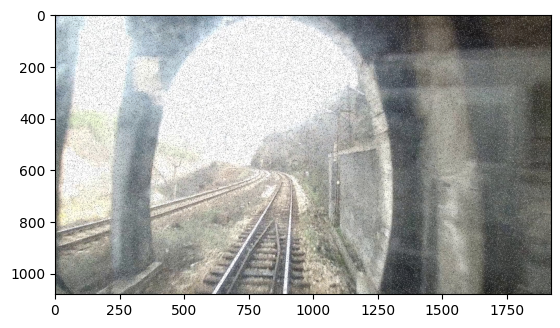

In [31]:
import matplotlib.pyplot as plt
plt.imshow(test_dataset["test"][0]["image"])
plt.show()

In [34]:
test_dataset.push_to_hub("BhavanaMalla/railsem19_test_split_salt_and_pepper", private=True)

Uploading the dataset shards:   0%|          | 0/10 [00:00<?, ?it/s]

Map:   0%|          | 0/179 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/179 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/179 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/179 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/179 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/BhavanaMalla/railsem19_test_split_salt_and_pepper/commit/58d9104ddce02eb5565102a5a47d3d913e456df1', commit_message='Upload dataset', commit_description='', oid='58d9104ddce02eb5565102a5a47d3d913e456df1', pr_url=None, pr_revision=None, pr_num=None)

In [40]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/test_results_faithful-snowball-148_baseline_200_10_Unet_Resnet101.csv')

# Display the first few rows of the DataFrame to check the data
print(df.head(), df.columns)

# Calculate the standard deviation for IoU and accuracy
iou_std = df["test_IoUs"].std()
miou = df["test_IoUs"].mean()
accuracy_std = df["test_accs"].std()
macc = df["test_accs"].mean()

# Print the results
print(f'Standard Deviation of IoU: {iou_std}')
print(f'Standard Deviation of Accuracy: {accuracy_std}')


# Print the results
print(f'mIoU: {miou:.4f} ± {iou_std:.4f}')
print(f'mAcc: {macc:.4f} ± {accuracy_std:.4f}')

   test_IoUs  test_accs
0   0.669065   0.807451
1   0.831778   0.903945
2   0.816035   0.870243
3   0.798293   0.866855
4   0.918232   0.953507 Index(['test_IoUs', 'test_accs'], dtype='object')
Standard Deviation of IoU: 0.09192977125199774
Standard Deviation of Accuracy: 0.06881988331357983
mIoU: 0.8012 ± 0.0919
mAcc: 0.8736 ± 0.0688


In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/Master\ Thesis/checkpoints/unet_r101/model_uncertain_rich-paper-100.pt .

In [ ]:
!cp -r /content/drive/MyDrive/Colab\ Notebooks/Master\ Thesis/checkpoints/Thesis .

In [ ]:
import torch
import torch.nn as nn
from segmentation_models_pytorch.encoders.resnet import ResNetEncoder


class ResNetEncoderDropout(ResNetEncoder):
    def __init__(self, dropout_prob=0.5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        features = []   # List of features from each layer
        features.append(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        features.append(x)

        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.dropout(x)
        features.append(x)

        x = self.layer2(x)
        x = self.dropout(x)
        features.append(x)

        x = self.layer3(x)
        x = self.dropout(x)
        features.append(x)

        x = self.layer4(x)
        x = self.dropout(x)
        features.append(x)

        return features

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders.resnet import pretrained_settings
from torchvision.models.resnet import Bottleneck
import torch.utils.model_zoo as model_zoo

model = smp.Unet(encoder_name="resnet101",
                 activation=None,
                 encoder_depth=5,
                 classes=13,
                 encoder_weights="imagenet",
                 )
params = {"out_channels": (3, 64, 256, 512, 1024, 2048),
          "block": Bottleneck,
          "layers": [3, 4, 23, 3], "depth": 5}
model.encoder = ResNetEncoderDropout(dropout_prob=0.5, **params)
model.encoder.set_in_channels(3)
model.encoder.load_state_dict(model_zoo.load_url(pretrained_settings["resnet101"]["imagenet"]["url"]))

In [ ]:
import sys

# Add the folder containing your module to the module search path
sys.path.append('/content/Thesis/modelling/')


In [ ]:
import torch
from Thesis import modelling

state_dict = torch.load(f="/content/model_uncertain_rich-paper-100.pt")
model.load_state_dict(state_dict)

OrderedDict([('encoder.conv1.weight', tensor([[[[ 2.0513e-02, -3.8735e-03, -1.7543e-02,  ..., -1.3931e-02,
           -1.7924e-04,  1.0794e-02],
          [-4.1554e-03,  3.2880e-03, -1.5709e-02,  ..., -8.3731e-02,
           -7.4033e-02, -3.9526e-02],
          [ 3.0237e-03,  2.6485e-02,  5.0703e-02,  ...,  3.3801e-02,
            1.4256e-02,  2.8604e-02],
          ...,
          [-3.7951e-02, -1.3115e-01, -3.0451e-01,  ..., -3.7421e-01,
           -1.3031e-01,  4.2387e-02],
          [ 1.3435e-02,  2.1906e-02,  5.4001e-03,  ..., -1.6496e-01,
           -1.8307e-01, -9.8290e-02],
          [-3.2306e-02, -1.2814e-02,  4.8826e-02,  ...,  1.6345e-01,
            1.0344e-01, -1.3650e-02]],

         [[ 1.0139e-02, -4.2705e-03, -1.0408e-02,  ..., -1.1319e-02,
            1.7522e-02,  2.1490e-02],
          [-6.1192e-03,  1.1348e-02, -6.7461e-03,  ..., -7.7825e-02,
           -5.7567e-02, -1.9637e-02],
          [-2.1341e-03,  3.2706e-02,  7.7185e-02,  ...,  9.0099e-02,
            5.2663e-

<All keys matched successfully>

In [1]:
import torch
mylist = [1, 2]
a = torch.Tensor(mylist)
a.shape, len(a), a

(torch.Size([2]), 2, tensor([1., 2.]))

In [44]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

def area_under_risk_rejection_rate_curve(y_true, y_prob, y_pred=None, selection_scores=None, risk_func=accuracy_score,
                                         attributes=None, num_bins=10, subgroup_ids=None,
                                         return_counts=False):
    """ Computes risk vs rejection rate curve and the area under this curve. Similar to risk-coverage curves [3]_ where
    coverage instead of rejection rate is used.

    References:
        .. [3] Franc, Vojtech, and Daniel Prusa. "On discriminative learning of prediction uncertainty."
         In International Conference on Machine Learning, pp. 1963-1971. 2019.

    Args:
        y_true: array-like of shape (n_samples,)
            ground truth labels.
        y_prob: array-like of shape (n_samples, n_classes).
            Probability scores from the base model.
        y_pred: array-like of shape (n_samples,)
            predicted labels.
        selection_scores: scores corresponding to certainty in the predicted labels.
        risk_func: risk function under consideration.
        attributes: (optional) if risk function is a fairness metric also pass the protected attribute name.
        num_bins: number of bins.
        subgroup_ids: (optional) selectively compute risk on a subgroup of the samples specified by subgroup_ids.
        return_counts: set to True to return counts also.

    Returns:
        float or tuple:
            - aurrrc (float): area under risk rejection rate curve.
            - rejection_rates (list): rejection rates for each bin (returned only if return_counts is True).
            - selection_thresholds (list): selection threshold for each bin (returned only if return_counts is True).
            - risks (list): risk in each bin (returned only if return_counts is True).

    """
    print(f"y_true: {y_true.shape}, y_prob: {y_prob.shape}")
    if selection_scores is None:
        assert len(y_prob.shape) > 1, "y_prob should be array-like of shape (n_samples, n_classes)"
        selection_scores = y_prob[np.arange(y_prob.shape[0]), np.argmax(y_prob, axis=1)]

    if y_pred is None:
        assert len(y_prob.shape) > 1, "y_prob should be array-like of shape (n_samples, n_classes)"
        y_pred = np.argmax(y_prob, axis=1)

    order = np.argsort(selection_scores)[::-1]

    rejection_rates = []
    selection_thresholds = []
    risks = []
    for bin_id in range(num_bins):
        samples_in_bin = len(y_true) // num_bins
        selection_threshold = selection_scores[order[samples_in_bin * (bin_id+1)-1]]
        selection_thresholds.append(selection_threshold)
        ids = selection_scores >= selection_threshold
        if sum(ids) > 0:
            if attributes is None:
                if isinstance(y_true, pd.Series):
                    y_true_numpy = y_true.values
                else:
                    y_true_numpy = y_true
                if subgroup_ids is None:
                    risk_value = 1.0 - risk_func(y_true_numpy[ids], y_pred[ids])
                else:
                    if sum(subgroup_ids & ids) > 0:
                        risk_value = 1.0 - risk_func(y_true_numpy[subgroup_ids & ids], y_pred[subgroup_ids & ids])
                    else:
                        risk_value = 0.0
            else:
                risk_value = risk_func(y_true.iloc[ids], y_pred[ids], prot_attr=attributes)
        else:
            risk_value = 0.0
        risks.append(risk_value)
        rejection_rates.append(1.0 - 1.0 * sum(ids) / len(y_true))

    aurrrc = np.nanmean(risks)

    if not return_counts:
        return aurrrc
    else:
        return aurrrc, rejection_rates, selection_thresholds, risks

In [67]:
y_true = torch.randint(0, 12, size=(2, 1080, 1920))
y_probs = torch.softmax(torch.randn(2, 13, 1080, 1920), dim=1)

aurrrc, rejection_rates, selection_thresholds, risks = area_under_risk_rejection_rate_curve(y_true.view(-1).numpy(), y_probs.view(-1, 13).numpy(), return_counts=True)
print(aurrrc, rejection_rates, selection_thresholds, risks)

y_true: (4147200,), y_prob: (4147200, 13)
0.922831420262964 [0.9, 0.7999997588734568, 0.7, 0.5999997588734568, 0.4999997588734568, 0.4, 0.30000000000000004, 0.19999999999999996, 0.09999999999999998, 0.0] [0.40606073, 0.3358974, 0.2919572, 0.2587305, 0.2311717, 0.20659545, 0.1834063, 0.15987776, 0.13252239, 0.031747848] [0.9225959683641975, 0.9229601623261932, 0.9229560506687243, 0.922785299246902, 0.9228308628323385, 0.9227659625771605, 0.922820560515873, 0.9228364920910493, 0.9228314686213992, 0.9229313753858025]


In [56]:
a = torch.Tensor(10)
a.shape, a[0]

(torch.Size([10]), tensor(-3.3724e-18))

In [65]:
import torch
import torch.nn.functional as F
from torchmetrics import Metric
from typing import List
from sklearn.metrics import accuracy_score

class AreaUnderRiskRejectionRateCurve(Metric):
    def __init__(self, num_bins=10, risk_func=accuracy_score, thresholds: List[float]=None, **kwargs):
        super().__init__(**kwargs)
        self.num_bins = num_bins
        self.risk_func = risk_func
        if thresholds is not None:
            self.thresholds = torch.Tensor(thresholds)
        else:
            self.thresholds = thresholds
        self.add_state("rejection_rates", default=torch.zeros(1, self.num_bins), dist_reduce_fx="cat")
        self.add_state("selection_thresholds", default=torch.zeros(1, self.num_bins), dist_reduce_fx="cat")
        self.add_state("risks", default=torch.zeros(1, self.num_bins), dist_reduce_fx="cat")

    def update(self, y_prob, y_true, selection_scores=None):
        assert y_prob.dim() == 4, "y_prob should be a tensor of shape (batch_size, num_classes, height, width)"

        bs, num_classes, height, width = y_prob.shape
        selection_thresholds = torch.Tensor(self.num_bins)
        rejection_rates = torch.Tensor(self.num_bins)
        risks = torch.Tensor(self.num_bins)

        if selection_scores is None:
            # Get the selection scores and indices of maximum probability
            selection_scores, _ = torch.max(y_prob, dim=1)
            selection_scores = selection_scores.view(-1)  # (bs, -1)

        # Sort selection_scores tensor in descending order
        order = torch.argsort(selection_scores, descending=True)

        y_pred = torch.argmax(y_prob, dim=1).view(-1)
        y_true = y_true.view(-1)

        assert y_pred.shape == y_true.shape == selection_scores.shape, f"Shapes Mismatch y_pred: {y_pred.shape}, y_true: {y_true.shape}, selection_scores: {selection_scores.shape}"

        for bin_id in range(self.num_bins):
            samples_in_bin = (bs * height * width) // self.num_bins
            # Checking fixed thresholds was given by user or not
            if self.thresholds is not None:
                assert self.num_bins == len(self.thresholds), "Num of thresholds should be same as num_bins"
                selection_threshold = self.thresholds[bin_id]
                selection_thresholds[bin_id] = selection_threshold
            else:
                # Getting selection threshold from data - accurate but time taking
                selection_threshold = selection_scores[order[samples_in_bin * (bin_id + 1) - 1]]
                selection_thresholds[bin_id] = selection_threshold # appending per bin and also aggregating per batch

            ids = selection_scores >= selection_threshold

            risk_value = 0.0
            if torch.sum(ids) > 0:
                risk_value = 1.0 - self.risk_func(y_true[ids], y_pred[ids])

            risks[bin_id] = risk_value
            rejection_rate = 1.0 - 1.0 * torch.sum(ids) / len(y_true)
            rejection_rates[bin_id] = rejection_rate

        self.selection_thresholds = torch.cat((self.selection_thresholds, selection_thresholds.view(1, -1)), dim=0)
        self.rejection_rates = torch.cat((self.rejection_rates, rejection_rates.view(1, -1)), dim=0)
        self.risks = torch.cat((self.risks, risks.view(1, -1)), dim=0)


    def compute(self):
        print("compute")
        print(f"rejection_rates: {self.rejection_rates.shape}, {self.rejection_rates}")
        print(f"selection_thresholds: {self.selection_thresholds.shape}, {self.selection_thresholds}")
        print(f"risks: {self.risks.shape}, {self.risks}")

        # Compute mean along the first dimension (axis 0) to aggregate across batches
        rejection_rates = torch.mean(torch.nan_to_num(self.rejection_rates[1:], nan=0), dim=0)
        selection_thresholds = torch.mean(torch.nan_to_num(self.selection_thresholds[1:], nan=0), dim=0)
        risks = torch.mean(torch.nan_to_num(self.risks[1:], nan=0), dim=0)

        aurrrc = torch.nanmean(risks)
        return aurrrc, rejection_rates, selection_thresholds, risks

    def reset(self):
        # Reinitialize the tensor with zeros
        self.selection_thresholds = torch.zeros(1, self.num_bins)
        self.rejection_rates = torch.zeros(1, self.num_bins)
        self.risks = torch.zeros(1, self.num_bins)

In [71]:
y_probs[0].shape, y_probs[0].unsqueeze(0).shape, y_true[0].shape, y_true[0].unsqueeze(0).shape

(torch.Size([13, 1080, 1920]),
 torch.Size([1, 13, 1080, 1920]),
 torch.Size([1080, 1920]),
 torch.Size([1, 1080, 1920]))

In [72]:
aurrc_metric = AreaUnderRiskRejectionRateCurve()
for i in range(2):
    aurrc_metric.update(y_probs[i].unsqueeze(0), y_true[i].unsqueeze(0))
aurrrc, rejection_rates, selection_thresholds, risks = aurrc_metric.compute()
print("------------------------------------------------------")
print(aurrrc, rejection_rates, selection_thresholds, risks)


# 0.922831420262964
 #[0.9, 0.7999997588734568, 0.7, 0.5999997588734568, 0.4999997588734568, 0.4, 0.30000000000000004, 0.19999999999999996, 0.09999999999999998, 0.0]
  # [0.40606073, 0.3358974, 0.2919572, 0.2587305, 0.2311717, 0.20659545, 0.1834063, 0.15987776, 0.13252239, 0.031747848]
   #[0.9225959683641975, 0.9229601623261932, 0.9229560506687243, 0.922785299246902, 0.9228308628323385, 0.9227659625771605, 0.922820560515873, 0.9228364920910493, 0.9228314686213992, 0.9229313753858025]

compute
rejection_rates: torch.Size([3, 10]), tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000, 0.2000, 0.1000,
         0.0000],
        [0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000, 0.2000, 0.1000,
         0.0000]])
selection_thresholds: torch.Size([3, 10]), tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4106, 0.3454, 0.3062, 0.2774, 0.2543, 0.2342, 0.2156, 0.1969, 0.1758,
         0.0956],
        [0.4105, 0.3451, 0.3060, 0.2774, 0.2542, 0.2341, 0.2154, 0.1969, 0.1758,
         0.1015]])
risks: torch.Size([3, 10]), tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9219, 0.9225, 0.9227, 0.9228, 0.9229, 0.9232, 0.9231, 0.9232, 0.9231,
         0.9231],
        [0.9225, 0.9227, 0.9228, 0.9231, 0.9231, 0.9232, 0.9233, 0.9231, 0.9231,
        

In [33]:
import torch
total_correct = 0
total_samples = 0

# samples_certainties holds a tensor of size (N, 2) of N samples, for each its certainty and whether it was a correct prediction. Position 0 is the confidences and 1 is the correctness
samples_certainties = torch.empty((0, 2))
y_true = torch.randint(0, 12, size=(1, 1080, 1920))
y_probs = torch.softmax(torch.randn(1, 13, 1080, 1920), dim=1)

# logic
for i in range(3):
    y = y_true.view(-1)
    y_pred = torch.max(y_probs, dim=1)
    certainties = y_pred[0].view(-1)
    correct = y_pred[1].view(-1) == y
    total_correct += correct.sum().item()
    print(f"correct.sum().item(): {correct.sum().item()}")
    total_samples += y_true.shape[0] * y_true.shape[1] * y_true.shape[2]
    print(f"y_true.shape[0] * y_true.shape[1] * y_true.shape[2]: {y_true.shape[0] * y_true.shape[1] * y_true.shape[2]}")
    samples_info = torch.stack((certainties, correct))
    print(f"samples_info.transpose(0, 1): {samples_info.transpose(0, 1)}")
    samples_certainties = torch.vstack((samples_certainties, samples_info.transpose(0, 1)))

accuracy = (total_correct / total_samples) * 100
print(f"accuracy: {accuracy}")

indices_sorting_by_confidence = torch.argsort(samples_certainties[:, 0], descending=True)
samples_certainties = samples_certainties[indices_sorting_by_confidence]
print(f"indices_sorting_by_confidence: {indices_sorting_by_confidence.shape}, {indices_sorting_by_confidence}")
print(f"samples_certainties: {samples_certainties.shape}, {samples_certainties}")



correct.sum().item(): 158853
y_true.shape[0] * y_true.shape[1] * y_true.shape[2]: 2073600
samples_info.transpose(0, 1): tensor([[0.3197, 0.0000],
        [0.1968, 0.0000],
        [0.3602, 0.0000],
        ...,
        [0.2267, 0.0000],
        [0.5549, 0.0000],
        [0.3079, 0.0000]])
correct.sum().item(): 158853
y_true.shape[0] * y_true.shape[1] * y_true.shape[2]: 2073600
samples_info.transpose(0, 1): tensor([[0.3197, 0.0000],
        [0.1968, 0.0000],
        [0.3602, 0.0000],
        ...,
        [0.2267, 0.0000],
        [0.5549, 0.0000],
        [0.3079, 0.0000]])
correct.sum().item(): 158853
y_true.shape[0] * y_true.shape[1] * y_true.shape[2]: 2073600
samples_info.transpose(0, 1): tensor([[0.3197, 0.0000],
        [0.1968, 0.0000],
        [0.3602, 0.0000],
        ...,
        [0.2267, 0.0000],
        [0.5549, 0.0000],
        [0.3079, 0.0000]])
accuracy: 7.660734953703703
indices_sorting_by_confidence: torch.Size([6220800]), tensor([ 790908, 2864508, 4938108,  ..., 3699705

In [34]:
def AURC_calc(samples_certainties, sort=True):
    if sort:
        indices_sorting_by_confidence = torch.argsort(samples_certainties[:, 0], descending=True)
        samples_certainties = samples_certainties[indices_sorting_by_confidence]
    total_samples = samples_certainties.shape[0]
    AURC = 0
    incorrect_num = 0
    for i in range(total_samples):
        incorrect_num += 1 - int(samples_certainties[i][1])
        AURC += (incorrect_num / (i + 1))
    AURC = AURC / total_samples
    return AURC


def EAURC_calc(AURC, accuracy):
    risk = 1 - (accuracy / 100)
    # From https://arxiv.org/abs/1805.08206 :
    optimal_AURC = risk + (1-risk)*np.log(1-risk+1e-6)
    return AURC - optimal_AURC

aurc = AURC_calc(samples_certainties)
earuc = EAURC_calc(aurc, accuracy)

print(f"aurc: {aurc}")
print(f"earuc: {earuc}")

aurc: 0.9231126915905078
earuc: 0.1965280916590707


In [35]:
from torchmetrics import Metric

class AURC(Metric):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.add_state("AURC", torch.Tensor([0.0]), dist_reduce_fx="sum")
        self.add_state("total_pixels", torch.Tensor([0]), dist_reduce_fx="sum")
        self.add_state("total_correct", torch.Tensor([0]), dist_reduce_fx="sum")

    def update(self, y_prob, y_true):
        print("inside")
        samples_certainties = torch.empty((0, 2))
        bs, num_classes, height, width = y_prob.shape
        print(f"y_prob: {y_prob.shape}")
        certainities, y_pred = torch.max(y_prob, dim=1)
        print(f"certainities before: {certainities.shape}, {certainities}")
        print(f"y_pred before: {y_pred.shape}, {y_pred}")
        certainities_flat = certainities.view(-1)
        y_pred_flat = y_pred.view(-1)
        y_true_flat = y_true.view(-1)
        print("update")
        print(f"certainties flatten: {certainities_flat.shape}")
        assert y_pred_flat.shape == y_true_flat.shape, "y_true and y_pred shapes do not match"
        correct = y_pred_flat == y_true_flat
        print(f"correct: {correct.shape}")
        self.total_correct += correct.sum().item()
        samples_info = torch.stack((certainities_flat, correct))
        print(f"samples_info = torch.stack((certainities_flat, correct)): {samples_info.shape}") # 2, bs*h*w,
        print(f"samples_certainties: {samples_certainties.shape}, samples_info.transpose: {samples_info.transpose(0, 1).shape}")
        samples_certainties = torch.vstack((samples_certainties, samples_info.transpose(0, 1)))
        print(f"samples_certainties = torch.vstack((samples_certainties, samples_info.transpose(0, 1))): {samples_certainties.shape}")

        indices_sorting_by_confidence = torch.argsort(samples_certainties[:, 0], descending=True)
        print(f"indices_sorting_by_confidence = torch.argsort(samples_certainties[:, 0], descending=True): {indices_sorting_by_confidence.shape}, {indices_sorting_by_confidence}")
        samples_certainties = samples_certainties[indices_sorting_by_confidence]
        print(f"samples_certainties = samples_certainties[indices_sorting_by_confidence]: {samples_certainties.shape}") # torch.Size([4147200, 2])

        total_pixels = bs * height * width
        self.total_pixels += total_pixels

        # Do it incrementally
        # Calculate incorrect_num for each pixel
        incorrect_num_per_pixel = 1 - samples_certainties[:, 1].int()
        # Calculate cumulative sum of incorrect_num
        cumulative_incorrect_num = incorrect_num_per_pixel.cumsum(dim=0)
        # Calculate AURC for each pixel
        AURC_per_pixel = cumulative_incorrect_num / torch.arange(1, total_pixels + 1, device=cumulative_incorrect_num.device)

        # Sum up AURC for all pixels to get total AURC
        self.AURC += AURC_per_pixel.sum().item()


    def compute(self):
        AURC = self.AURC / self.total_pixels
        accuracy = (self.total_correct / self.total_pixels) * 100
        risk = 1 - (accuracy.item() / 100)
        optimal_AURC = risk + (1 - risk) * np.log(1 - risk + 1e-6) # https://arxiv.org/abs/1805.08206
        eurc = AURC - optimal_AURC
        return AURC, eurc

    def reset(self):
        # Reinitialize the tensor with zeros
        self.AURC.zero_()
        self.total_pixels.zero_()
        self.total_correct.zero_()

In [36]:
aurc_metric = AURC()

for i in range(3):
    aurc_metric.update(y_probs, y_true)

AURC_metric, eurc_metric = aurc_metric.compute()

print(f"AURC_metric: {AURC_metric}")
print(f"eurc_metric: {eurc_metric}")

inside
y_prob: torch.Size([1, 13, 1080, 1920])
certainities before: torch.Size([1, 1080, 1920]), tensor([[[0.3197, 0.1968, 0.3602,  ..., 0.2573, 0.2460, 0.2696],
         [0.2274, 0.2984, 0.2001,  ..., 0.2446, 0.2537, 0.2460],
         [0.3491, 0.1565, 0.2627,  ..., 0.1516, 0.1879, 0.3081],
         ...,
         [0.3764, 0.1870, 0.1704,  ..., 0.2814, 0.1506, 0.1876],
         [0.1725, 0.3422, 0.2094,  ..., 0.2020, 0.4518, 0.2255],
         [0.2190, 0.3271, 0.1810,  ..., 0.2267, 0.5549, 0.3079]]])
y_pred before: torch.Size([1, 1080, 1920]), tensor([[[ 9,  6, 11,  ..., 10,  0,  8],
         [ 6,  0,  3,  ...,  6,  5, 10],
         [ 2, 10,  4,  ...,  1, 11,  6],
         ...,
         [12,  5, 11,  ...,  6,  3, 12],
         [10,  6,  4,  ...,  6,  2,  9],
         [ 5, 11, 12,  ...,  0,  7, 11]]])
update
certainties flatten: torch.Size([2073600])
correct: torch.Size([2073600])
samples_info = torch.stack((certainities_flat, correct)): torch.Size([2, 2073600])
samples_certainties: torch.

In [5]:
from typing import Literal

import torch
import torch.nn.functional as F
from torch import Tensor
from torchmetrics import Metric
from torchmetrics.utilities.data import dim_zero_cat

class BrierScore(Metric):
    def __init__(self, num_classes: int, top_class: bool = False,
                 reduction: Literal["mean", "sum", "none", None] = "mean",
                 **kwargs,) -> None:
        r"""
        Args:
            num_classes (int): Number of classes
            top_class (bool, optional): If true, compute the Brier score for the top class only. Defaults to False.
            reduction (str, optional): Determines how to reduce over the batch dimension
                - "mean" [default]: Averages score across samples
                - "sum": Sum score across samples
                - "none" or None: Returns score per sample
        Inputs:
            - probs (Tensor): softmax probs of shape(bs, num_classes) where bs is the batch size
            - target (Tensor): A tensor of ground truth labels of shape (bs,)
        """
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.top_class = top_class
        self.reduction = reduction

        allowed_reduction = ("sum", "mean", "none", None)
        if reduction not in allowed_reduction:
            raise ValueError(
                "Expected argument `reduction` to be one of ",
                f"{allowed_reduction} but got {reduction}",
            )
        if self.reduction in ["mean", "sum"]:
            self.add_state("values", default=torch.tensor(0.0), dist_reduce_fx="sum")
        else:
            self.add_state("values", default=[], dist_reduce_fx="cat")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, probs: Tensor, target: Tensor) -> None:
        if target.ndim == 1:
            target = F.one_hot(target, self.num_classes)

        if probs.ndim == 2:
            batch_size = probs.size(0)
        else:
            raise ValueError(
                f"Expected `probs` to be of shape (batch, num_classes) but got {probs.shape}"
            )

        if self.top_class:
            probs, indices = probs.max(dim=-1)
            # https://medium.com/analytics-vidhya/understanding-torch-gather-function-in-pytorch-f90db58b3c51
            target = target.gather(dim=-1, index=indices.unsqueeze(-1)).squeeze(-1)
            brier_score = F.mse_loss(probs, target, reduction="none")
        else:
            brier_score = F.mse_loss(probs, target, reduction="none").sum(dim=-1)

        if self.reduction is None or self.reduction == "none":
            self.values.append(brier_score)
        else:
            self.values += brier_score.sum()
            self.total += batch_size

    def compute(self) -> Tensor:
        values = dim_zero_cat(self.values)
        if self.reduction == "sum":
            return values.sum(dim=-1)
        if self.reduction == "mean":
            return values.sum(dim=-1) / self.total
        return values

In [7]:
from typing import Any

class MulticlassBrierScore(Metric):
    def __init__(self, num_classes: int, **kwargs: Any,) -> None:
        super().__init__(**kwargs)
        self.add_state("total_brier_score", default=torch.tensor([0.0]), dist_reduce_fx="sum")
        self.add_state("total_num_pixels", default=torch.tensor([0]), dist_reduce_fx="sum")
        self.num_classes = num_classes

    def update(self, y_prob: Tensor, y_true: Tensor) -> None:
        assert y_prob.dim() == 4, "y_prob should be a tensor of shape (batch_size, num_classes, height, width)"

        bs, num_classes, height, width = y_prob.shape
        y_true_flat = y_true.view(bs, -1)  # Flatten the ground truth labels
        y_target = torch.zeros(bs, num_classes, height*width, device=y_prob.device) # Shape: (batch_size, num_classes, height*width)
        y_target.scatter_(dim=1, index=y_true_flat.unsqueeze(1).long(), value=1.0)  # One-hot encoding, scatter along the class dimension, shape: (batch_size, num_classes, height*width)

        y_prob_reshaped = y_prob.view(bs, num_classes, -1)
        squared_error = (y_target - y_prob_reshaped) ** 2  # Compute squared errors, shape: (batch_size, num_classes, height*width)
        sum_pixel = torch.sum(squared_error, dim=1)  # Sum squared errors along the class dimension, shape: (batch_size, height*width)
        total_num_pixels = bs * height * width  # Total number of pixels in the batch

        # Update total brier score and total number of pixels
        self.total_brier_score += torch.sum(sum_pixel) # sum the mse of all the pixels of all the samples
        self.total_num_pixels += total_num_pixels

    def compute(self):
        if self.total_num_pixels == 0:
            return torch.tensor(0.0)
        return self.total_brier_score / self.total_num_pixels

    def reset(self):
        self.total_brier_score.zero_()
        self.total_num_pixels.zero_()

In [18]:
import torch
y_prob = torch.softmax(torch.randn(3, 13, 1024, 1024), dim=1)
y_true = torch.randint(0, 13, (3, 1024, 1024))

mymetric = MulticlassBrierScore(num_classes=13)
for i in range(3):
    print(y_prob[i].unsqueeze(0).shape,  y_true[i].unsqueeze(0).shape)
    mymetric.update(y_prob[i].unsqueeze(0), y_true[i].unsqueeze(0))
myscore = mymetric.compute()

newmetric = BrierScore(num_classes=13, reduction="mean")
for i in range(3):
    print(y_prob[i].unsqueeze(0).view(-1, 13).shape,  y_true[i].unsqueeze(0).view(-1).shape)
    newmetric.update(y_prob[i].unsqueeze(0).view(-1, 13), y_true[i].unsqueeze(0).view(-1))
newscore = newmetric.compute()

myscore, newscore

torch.Size([1, 13, 1024, 1024]) torch.Size([1, 1024, 1024])
torch.Size([1, 13, 1024, 1024]) torch.Size([1, 1024, 1024])
torch.Size([1, 13, 1024, 1024]) torch.Size([1, 1024, 1024])
torch.Size([1048576, 13]) torch.Size([1048576])
torch.Size([1048576, 13]) torch.Size([1048576])
torch.Size([1048576, 13]) torch.Size([1048576])


(tensor(1.0035), tensor(1.0035))

In [19]:
newmetric = BrierScore(num_classes=13, reduction="none")
for i in range(3):
    print(y_prob[i].unsqueeze(0).view(-1, 13).shape,  y_true[i].unsqueeze(0).view(-1).shape)
    newmetric.update(y_prob[i].unsqueeze(0).view(-1, 13), y_true[i].unsqueeze(0).view(-1))
newscore_none = newmetric.compute()

newmetric = BrierScore(num_classes=13, reduction="sum")
for i in range(3):
    print(y_prob[i].unsqueeze(0).view(-1, 13).shape,  y_true[i].unsqueeze(0).view(-1).shape)
    newmetric.update(y_prob[i].unsqueeze(0).view(-1, 13), y_true[i].unsqueeze(0).view(-1))
newscore_sum = newmetric.compute()

newscore_none, newscore_none.shape, newscore_sum, newscore_sum.shape

torch.Size([1048576, 13]) torch.Size([1048576])
torch.Size([1048576, 13]) torch.Size([1048576])
torch.Size([1048576, 13]) torch.Size([1048576])
torch.Size([1048576, 13]) torch.Size([1048576])
torch.Size([1048576, 13]) torch.Size([1048576])
torch.Size([1048576, 13]) torch.Size([1048576])


(tensor([1.0567, 1.0356, 0.9246,  ..., 1.0203, 0.9237, 1.0236]),
 torch.Size([3145728]),
 tensor(3156822.5000),
 torch.Size([]))

In [23]:
from typing import Any, Literal

import torch
import torch.nn.functional as F
from torch import Tensor
from torchmetrics import Metric
from torchmetrics.utilities.data import dim_zero_cat


class NegativeLogLikelihood(Metric):
    is_differentiable = False
    higher_is_better = False
    full_state_update = False

    def __init__(self, reduction: Literal["mean", "sum", "none", None] = "mean", **kwargs: Any,) -> None:
        """The Negative Log Likelihood Metric.

        Args:
            reduction (str, optional): Determines how to reduce over the batch dimension
                - 'mean' [default]: Averages score across pixels
                - 'sum': Sum score across pixels
                - 'none' or None: Returns score per pixel
        Args:
            probs: (bs, num_classes, h, w) softmax probs
            target: (bs, h, w)
        """
        super().__init__(**kwargs)
        allowed_reduction = ("sum", "mean", "none", None)
        if reduction not in allowed_reduction:
            raise ValueError(
                "Expected argument `reduction` to be one of ",
                f"{allowed_reduction} but got {reduction}",
            )
        self.reduction = reduction

        if self.reduction in ["mean", "sum"]:
            self.add_state("values", default=torch.tensor(0.0), dist_reduce_fx="sum",)
        else:
            self.add_state("values", default=[], dist_reduce_fx="cat")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, probs: Tensor, target: Tensor) -> None:
        """Compute the negative log likelihood loss."""
        bs, h, w = target.shape
        if self.reduction is None or self.reduction == "none":
            self.values.append(F.nll_loss(torch.log(probs), target, reduction="none"))
        else:
            self.values += F.nll_loss(torch.log(probs), target, reduction="sum")
            self.total += bs*h*w

    def compute(self) -> Tensor:
        values = dim_zero_cat(self.values)
        if self.reduction == "sum":
            return values.sum(dim=-1)
        if self.reduction == "mean":
            return values.sum(dim=-1) / self.total
        # reduction is None or "none"
        return values

In [24]:
import torch
y_prob = torch.softmax(torch.randn(3, 13, 1024, 1024), dim=1)
y_true = torch.randint(0, 13, (3, 1024, 1024))

metric = NegativeLogLikelihood(reduction="mean")
for i in range(3):
    print(y_prob[i].unsqueeze(0).shape,  y_true[i].unsqueeze(0).shape)
    metric.update(y_prob[i].unsqueeze(0), y_true[i].unsqueeze(0))
nllscore = metric.compute()
nllscore

torch.Size([1, 13, 1024, 1024]) torch.Size([1, 1024, 1024])
torch.Size([1, 13, 1024, 1024]) torch.Size([1, 1024, 1024])
torch.Size([1, 13, 1024, 1024]) torch.Size([1, 1024, 1024])


tensor(3.0062)

In [6]:
import torch
a = torch.zeros(1, 10)
b = torch.ones(10)
c = torch.cat((a, b.view(1, -1)))
d = torch.cat((a, b.view(1, -1)))
c.shape, d.shape, a, b, c, d, d[1:].shape, d[1:]

(torch.Size([2, 10]),
 torch.Size([2, 10]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 torch.Size([1, 10]),
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))

In [1]:
!pip install diffusers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 26.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinu

In [16]:
import torch
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

pipeline = AutoPipelineForInpainting.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16"
).to("cuda")
pipeline.enable_model_cpu_offload()


# load base and mask image
init_image = load_image("/content/rs00004.jpg")
mask_image = load_image("/content/persons.png")

generator = torch.Generator("cuda").manual_seed(92)
prompt = "concept art digital painting of an elven castle, inspired by lord of the rings, highly detailed, 8k"
image = pipeline(prompt=prompt, image=init_image, mask_image=mask_image, generator=generator).images[0]
make_image_grid([init_image, image], rows=1, cols=2)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
import torch
import accelerate
from diffusers import AutoPipelineForInpainting, AutoPipelineForImage2Image
from diffusers.utils import load_image, make_image_grid

pipeline = AutoPipelineForInpainting.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16, variant="fp16"
)
pipeline.enable_model_cpu_offload()
# # remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
# pipeline.enable_xformers_memory_efficient_attention()

# load base and mask image
init_image = load_image("/content/rs00010.jpg")
mask_image = load_image("/content/persons.png")

prompt = "picture of traffic light"
image_inpainting = pipeline(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

# resize image to 1024x1024 for SDXL
image_inpainting = image_inpainting.resize((1920, 1080))

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

(1920, 1080)


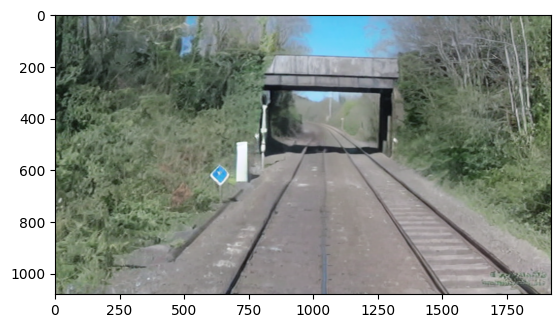

In [18]:
import matplotlib.pyplot as plt
print(image_inpainting.size)
plt.imshow(image_inpainting)

In [22]:
pipeline = AutoPipelineForInpainting.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16"
)
pipeline.enable_model_cpu_offload()

image = pipeline(prompt=prompt, image=image_inpainting, mask_image=mask_image, output_type="latent").images[0]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
print(type(image))

plt.imshow(image.detach().numpy().cpu())

<class 'torch.Tensor'>


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [7]:
from diffusers import AutoPipelineForInpainting
from diffusers.utils import make_image_grid

pipeline = AutoPipelineForImage2Image.from_pipe(pipeline)

image = pipeline(prompt=prompt, image=image).images[0]
make_image_grid([init_image, mask_image, image_inpainting, image], rows=2, cols=2)

Output hidden; open in https://colab.research.google.com to view.

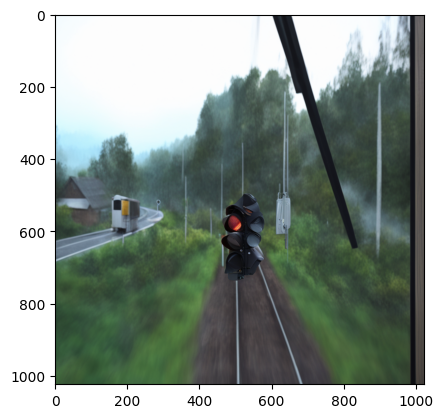

In [9]:
import matplotlib.pyplot as plt

plt.imshow(image)